Sentiment Analysis with RNNs
============================

This notebook is part of a series:

- Sentiment Analysis with RNNs - Disaster Tweets 
- Sentiment Analysis with RNNs - TripAdvisor Reviews
- Sentiment Analysis with RNNs - News Headlines Sarcasm

In this notebook we reviewed some techniques to perform sentiment analysis on a text dataset. 
We have found 4 different datasets on which we could conduct a sentiment analysis, each one containing a text and a sentiment (positive or negative).

- [IMDB Movies Dataset](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews)
- [Disaster tweets dataset](https://www.kaggle.com/competitions/nlp-getting-started)
- [Tripadvisor reviews](https://www.kaggle.com/datasets/andrewmvd/trip-advisor-hotel-reviews)
- [News headlines sarcasm detection](https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection)

This problem can be formulated as a binary classification of a text, based on the sentiment associated to each word and their structure in the sentence.

<a id="toc">Table of Contents</a>

1. [Data Analysis](#1)  
    [a. Dataset info](#1a)  
    [b. Dirty characters](#1b)
2. [Text Preprocessing](#2a)
3. [Model Experiments](#3)  
    [a. Simple FFN](#3a)  
    [b. Simple RNN](#3b)  
    [c. LSTM](#3c)  
    [d. GRU](#3d)  
    [e. 2 Layers LSTM](#3e)  
4. [Embedding Experiments](#4)  
    [a. LSTM - GloVe 6B300D](#4a)  
    [b. GRU - GloVe 6B300D](#4b)  
    [c. LSTM - GloVe Twitter 27B200D](#4c)  
    [d. GRU - GloVe 27B200D](#4d)  
5. [Contextual Embeddings](#5)

In [9]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

#Uncomment the desired dataset

##IMDB dataset
#imdb_path = '../input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv'
# data = pd.read_csv(imdb_path)
# X = data['review']
# y = pd.Series(np.where(data['sentiment'].str.contains("positive"), 1, 0))

##Disaster tweets dataset
dis_path = '../input/nlp-getting-started/train.csv'
data  = pd.read_csv(dis_path)
X = data['text']
y = data['target']

##TripAdvisor reviews
# trip_path = '../input/trip-advisor-hotel-reviews/tripadvisor_hotel_reviews.csv'
# data = pd.read_csv(trip_path)
# X = data['Review']
# y = pd.Series(np.where(data['Rating'] >3, 1, 0))

##News headlines sarcasm detection
# news_path = '../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json'
# data = pd.read_json(news_path, lines=True)
# X = data['headline']
# y = data['is_sarcastic']

# print(data.columns)
print(data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None


# 1. Data Analysis
<a href="#toc" id="1">Table Of Contents</a>  

First we determine if our dataset is balanced or not between positive and negative examples

0    4342
1    3271
Name: target, dtype: int64


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


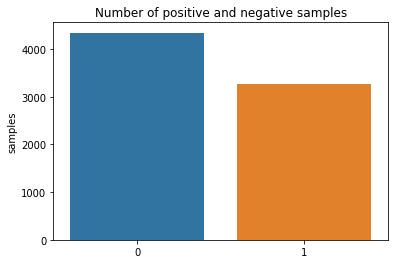

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

y_count =y.value_counts()
sns.barplot(y_count.index,y_count)
plt.gca().set_ylabel('samples')
plt.gca().set_title('Number of positive and negative samples')

print(y_count)

The twitter dataset is slightly unbalanced, with positive examples (tweets relative to disasters) being the 40% of the total.

## Characters/Words count
<a href="#toc" id="1a">Table Of Contents</a>

We can use some histograms to determine how the character and word count of the samples is distributed, in samples with positive or negative sentiment. Are positive or negative samples distributed in the same way or there is a difference in length?

151
108


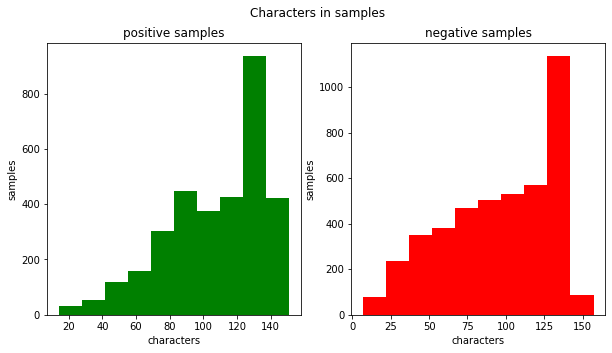

In [11]:
import math
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
X_len=X[y==1].str.len()
ax1.hist(X_len,color='green')
ax1.set_ylabel('samples')
ax1.set_xlabel('characters')
ax1.set_title('positive samples')

print(max(X_len))
print(int(X_len.mean()))

X_len=X[y==0].str.len()
ax2.hist(X_len,color='red')
ax2.set_ylabel('samples')
ax2.set_xlabel('characters')
ax2.set_title('negative samples')
fig.suptitle('Characters in samples')
plt.show()


Tweets have an average length of 108 characters, with a maximum length of 151.

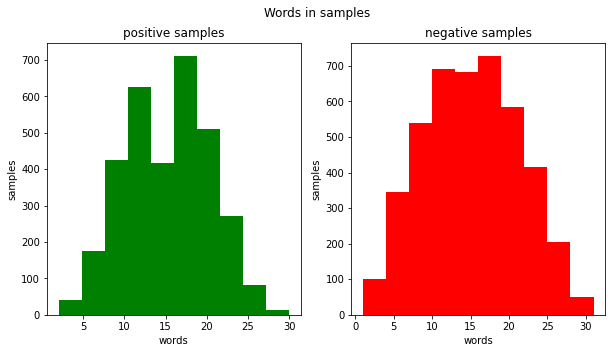

In [12]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
X_len=X[y==1].str.split().map(lambda x: len(x))
ax1.hist(X_len,color='green')
ax1.set_ylabel('samples')
ax1.set_xlabel('words')
ax1.set_title('positive samples')
X_len=X[y==0].str.split().map(lambda x: len(x))
ax2.hist(X_len,color='red')
ax2.set_ylabel('samples')
ax2.set_xlabel('words')
ax2.set_title('negative samples')
fig.suptitle('Words in samples')
plt.show()

## Dirty characters
<a href="#toc" id="1b">Table Of Contents</a>

Some datasets can contain samples with some dirty characters.
- HTML tags
- Links
- Hashtags
- Emoticons (both in single character :smile: or with composed characters :) )
- Non-ascii characters

Those characters have been removed to improve the quality of the dataset and obtain overall better results.

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


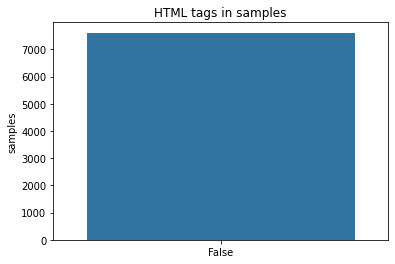

In [13]:
y_count = X.str.contains('<.*?>', regex= True, na=False).value_counts()
sns.barplot(y_count.index,y_count)
plt.gca().set_ylabel('samples')
plt.gca().set_title('HTML tags in samples')

X = X.str.replace(r'<.*?>','', regex= True)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


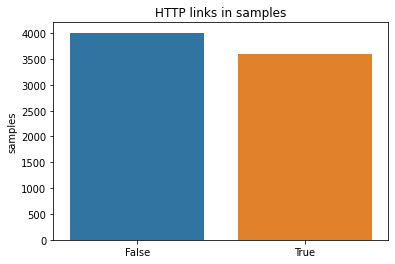

In [14]:
y_count = X.str.contains('http://+', regex= True, na=False).value_counts()
sns.barplot(y_count.index,y_count)
plt.gca().set_ylabel('samples')
plt.gca().set_title('HTTP links in samples')

X = X.str.replace(r'http://+','', regex= True)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


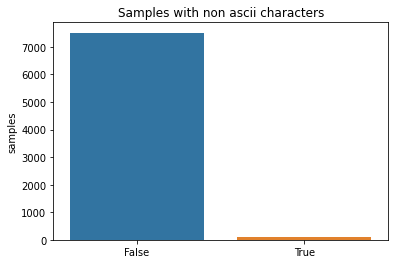

In [15]:
y_count = X.str.contains('[^[:ascii:]]', regex= True, na=False).value_counts()
sns.barplot(y_count.index,y_count)
plt.gca().set_ylabel('samples')
plt.gca().set_title('Samples with non ascii characters')

# print(X[X.str.contains('[^[:ascii:]]', regex= True, na=False)])
# print(X[49677])

X = X.str.replace(r'[^[:ascii:]]','', regex= True)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


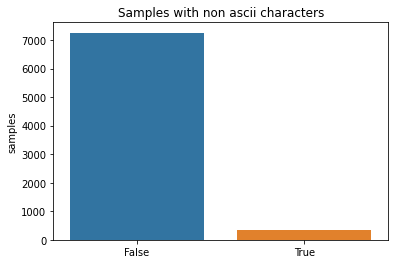

In [16]:
y_count = X.str.contains('&/?[a-z]+;', regex= True, na=False).value_counts()
sns.barplot(y_count.index,y_count)
plt.gca().set_ylabel('samples')
plt.gca().set_title('Samples with non ascii characters')

X = X.str.replace(r'&/?[a-z]+;','', regex= True)

# Text preprocessing
<a href="#toc" id="2">Table Of Contents</a>

Before feeding the text to the model, it needs to be tokenized.
I used the most basic [Tokenizer](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) to create the vocabulary using the train dataset, and then proceed to tokenize the train and test dataset.
There are a few parameters to decide
* Vocabulary size
* Dimension of the embedding: usually between 100 and 300
* Maximum length(in characters)
* What to do with sentences shorter or longer than maximum length
* Further reduction of the vocabulary with lemmatization or stemming.

We took a vocabulary of 1000 words, and chose a max length of 150, in accord with the size of the tweets. 
Longer tweets may be truncated, while shorter have been padded to reach an equal size of each batch. More advanced techniques may use dynamic batching, where maximum size is inferred in each batch and samples are padded accordingly.
Stemming was done with ``PorterStemmer``.

In [17]:
import nltk
import pandas as pd
import numpy as np
import re
from nltk.stem.porter import *

wpt = nltk.WordPunctTokenizer()

nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')


vocab_size = 1000
embedding_dim = 300
max_length = 150
trunc_type='post'
padding_type='post'
oov_tok = "<UNK>"

stemmer = PorterStemmer()

STEMMING = True
BATCH_SIZE = 64

def normalize_and_tokenize(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s!]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    if STEMMING:
        filtered_tokens = [stemmer.stem(token) for token in filtered_tokens]
    # re-create document from filtered tokens
    return ' '.join(filtered_tokens)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


With a WordCloud we visualize the most frequent words, we'd like that stopwords or dirty characters were not shown here

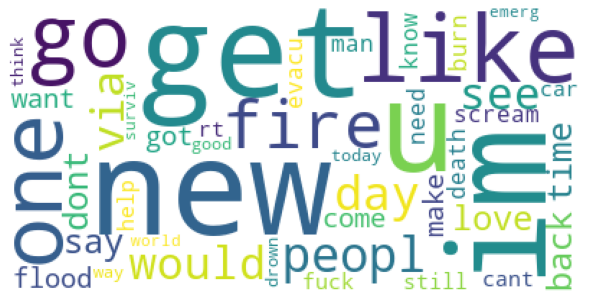

In [18]:
from wordcloud import WordCloud


X = X.map(normalize_and_tokenize)
wordcloud = WordCloud(
                background_color ='white',
                stopwords = stop_words,
                min_font_size = 10).generate(" ".join(X.to_list()))
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

In [137]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)

tokenizer = Tokenizer(num_words = vocab_size
                      ,oov_token=oov_tok
                     )

tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [138]:
# Need this block to get it to work with TensorFlow 2.x
import numpy as np
train_padded = np.array(train_padded)
train_labels = np.array(y_train)
test_padded = np.array(test_padded)
test_labels = np.array(y_test)

In [29]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# Model Experiments
<a href="#toc" id="3">Table Of Contents</a>
## Simple Feed Forward Network
<a href="#toc" id="3a"></a>

In [22]:
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.metrics import classification_report

optimizer=Adam(learning_rate=1e-4)

def evaluate(model,X_test,y_test):
    y_hat = model.predict(X_test,batch_size = BATCH_SIZE)
    y_hat = (y_hat > 0.5).astype(np.float32)
    if(len(y_hat.shape)>2):
        y_hat = y_hat[:,-1,0]
    report = classification_report(y_test, y_hat)
    return report

In [141]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 150, 300)          300000    
_________________________________________________________________
global_average_pooling1d_5 ( (None, 300)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 24)                7224      
_________________________________________________________________
dropout_8 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 25        
Total params: 307,249
Trainable params: 307,249
Non-trainable params: 0
_________________________________________________________________


### Training

Epoch 1/40
77/77 - 1s - loss: 0.6945 - accuracy: 0.4721 - val_loss: 0.6919 - val_accuracy: 0.5673
Epoch 2/40
77/77 - 0s - loss: 0.6914 - accuracy: 0.5675 - val_loss: 0.6907 - val_accuracy: 0.5673
Epoch 3/40
77/77 - 0s - loss: 0.6902 - accuracy: 0.5675 - val_loss: 0.6894 - val_accuracy: 0.5673
Epoch 4/40
77/77 - 0s - loss: 0.6890 - accuracy: 0.5675 - val_loss: 0.6874 - val_accuracy: 0.5673
Epoch 5/40
77/77 - 0s - loss: 0.6872 - accuracy: 0.5675 - val_loss: 0.6857 - val_accuracy: 0.5673
Epoch 6/40
77/77 - 0s - loss: 0.6864 - accuracy: 0.5675 - val_loss: 0.6849 - val_accuracy: 0.5673
Epoch 7/40
77/77 - 0s - loss: 0.6863 - accuracy: 0.5675 - val_loss: 0.6844 - val_accuracy: 0.5673
Epoch 8/40
77/77 - 0s - loss: 0.6856 - accuracy: 0.5675 - val_loss: 0.6840 - val_accuracy: 0.5673
Epoch 9/40
77/77 - 0s - loss: 0.6859 - accuracy: 0.5675 - val_loss: 0.6838 - val_accuracy: 0.5673
Epoch 10/40
77/77 - 0s - loss: 0.6839 - accuracy: 0.5675 - val_loss: 0.6833 - val_accuracy: 0.5673
Epoch 11/40
77/77 -

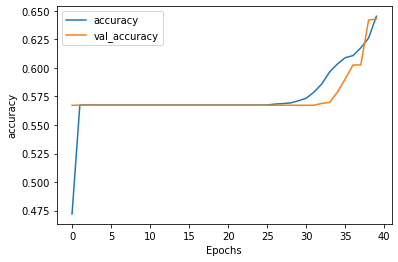

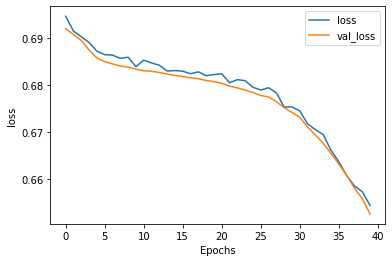

              precision    recall  f1-score   support

           0       0.61      1.00      0.76       886
           1       1.00      0.12      0.22       637

    accuracy                           0.63      1523
   macro avg       0.81      0.56      0.49      1523
weighted avg       0.77      0.63      0.53      1523



In [142]:
num_epochs = 40
history = model.fit(train_padded, train_labels, epochs=num_epochs, validation_split=0.2, batch_size = BATCH_SIZE, verbose=2)
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

report = evaluate(model,test_padded,test_labels)
print(report)

# Recurrent Neural Networks
<a href="#toc" id="3b">Table Of Contents</a>

For now disabled, they require too much time for training.
In addition, simple RNNs are subjected to vanishing gradient and the context is limited to a few time steps.

In [143]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(50, return_sequences=True,input_shape=(max_length, embedding_dim))),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 150, 300)          300000    
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 150, 100)          35100     
_________________________________________________________________
dropout_9 (Dropout)          (None, 150, 100)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 15000)             0         
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 15001     
Total params: 350,101
Trainable params: 350,101
Non-trainable params: 0
_________________________________________________________________


In [144]:
# num_epochs = 5
# history = model.fit(train_padded, train_labels, epochs=num_epochs, validation_split=0.2, verbose=2)
# plot_graphs(history, "accuracy")
# plot_graphs(history, "loss")

## LSTMs
<a href="#toc" id="3c">Table Of Contents</a>

In [145]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True,input_shape=(max_length, embedding_dim),dropout=0.5)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 150, 300)          300000    
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 150, 64)           85248     
_________________________________________________________________
dense_30 (Dense)             (None, 150, 24)           1560      
_________________________________________________________________
dense_31 (Dense)             (None, 150, 1)            25        
Total params: 386,833
Trainable params: 386,833
Non-trainable params: 0
_________________________________________________________________


Epoch 1/40
77/77 - 4s - loss: 0.6844 - accuracy: 0.5682 - val_loss: 0.6828 - val_accuracy: 0.5707
Epoch 2/40
77/77 - 1s - loss: 0.6824 - accuracy: 0.5724 - val_loss: 0.6811 - val_accuracy: 0.5753
Epoch 3/40
77/77 - 1s - loss: 0.6785 - accuracy: 0.5797 - val_loss: 0.6774 - val_accuracy: 0.5886
Epoch 4/40
77/77 - 1s - loss: 0.5771 - accuracy: 0.7172 - val_loss: 0.5350 - val_accuracy: 0.7641
Epoch 5/40
77/77 - 1s - loss: 0.4804 - accuracy: 0.8057 - val_loss: 0.5371 - val_accuracy: 0.7666
Epoch 6/40
77/77 - 1s - loss: 0.4756 - accuracy: 0.8156 - val_loss: 0.5273 - val_accuracy: 0.7821
Epoch 7/40
77/77 - 1s - loss: 0.5032 - accuracy: 0.8024 - val_loss: 0.5175 - val_accuracy: 0.7861
Epoch 8/40
77/77 - 1s - loss: 0.4963 - accuracy: 0.7977 - val_loss: 0.5401 - val_accuracy: 0.7703
Epoch 9/40
77/77 - 1s - loss: 0.5117 - accuracy: 0.7834 - val_loss: 0.5662 - val_accuracy: 0.7416
Epoch 10/40
77/77 - 1s - loss: 0.5263 - accuracy: 0.7592 - val_loss: 0.6122 - val_accuracy: 0.6706
Epoch 11/40
77/77 -

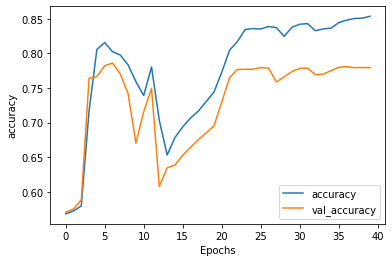

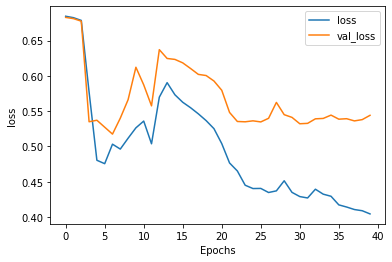

              precision    recall  f1-score   support

           0       0.78      0.88      0.83       886
           1       0.80      0.65      0.72       637

    accuracy                           0.79      1523
   macro avg       0.79      0.77      0.77      1523
weighted avg       0.79      0.79      0.78      1523



In [146]:
num_epochs = 40
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=39)

history = model.fit(train_padded, train_labels, epochs=num_epochs, validation_split=0.2,batch_size = BATCH_SIZE, verbose=2,callbacks=[callback])
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

report = evaluate(model,test_padded,test_labels)
print(report)

## GRUs
<a href="#toc" id="3d">Table Of Contents</a>

In [147]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32, return_sequences=True,input_shape=(max_length, embedding_dim),dropout=0.5)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 150, 300)          300000    
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 150, 64)           64128     
_________________________________________________________________
dense_32 (Dense)             (None, 150, 1)            65        
Total params: 364,193
Trainable params: 364,193
Non-trainable params: 0
_________________________________________________________________


Epoch 1/40
77/77 - 5s - loss: 0.6838 - accuracy: 0.5691 - val_loss: 0.6829 - val_accuracy: 0.5744
Epoch 2/40
77/77 - 1s - loss: 0.6816 - accuracy: 0.5754 - val_loss: 0.6809 - val_accuracy: 0.5753
Epoch 3/40
77/77 - 1s - loss: 0.6806 - accuracy: 0.5768 - val_loss: 0.6790 - val_accuracy: 0.5770
Epoch 4/40
77/77 - 1s - loss: 0.6775 - accuracy: 0.5793 - val_loss: 0.6769 - val_accuracy: 0.5796
Epoch 5/40
77/77 - 1s - loss: 0.6727 - accuracy: 0.5851 - val_loss: 0.6696 - val_accuracy: 0.5888
Epoch 6/40
77/77 - 1s - loss: 0.5840 - accuracy: 0.6957 - val_loss: 0.5278 - val_accuracy: 0.7755
Epoch 7/40
77/77 - 1s - loss: 0.4543 - accuracy: 0.8158 - val_loss: 0.5128 - val_accuracy: 0.7832
Epoch 8/40
77/77 - 1s - loss: 0.4361 - accuracy: 0.8253 - val_loss: 0.5038 - val_accuracy: 0.7799
Epoch 9/40
77/77 - 1s - loss: 0.4197 - accuracy: 0.8348 - val_loss: 0.5086 - val_accuracy: 0.7837
Epoch 10/40
77/77 - 1s - loss: 0.4130 - accuracy: 0.8372 - val_loss: 0.5018 - val_accuracy: 0.7820
Epoch 11/40
77/77 -

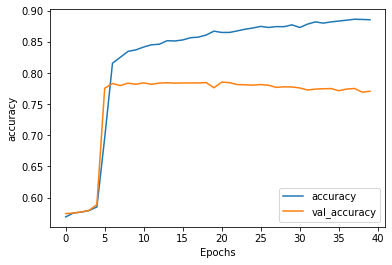

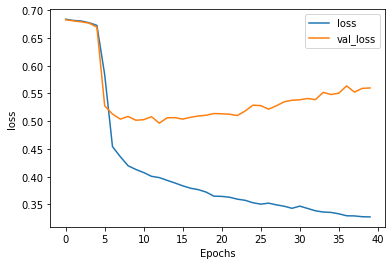

              precision    recall  f1-score   support

           0       0.80      0.86      0.83       886
           1       0.78      0.70      0.74       637

    accuracy                           0.79      1523
   macro avg       0.79      0.78      0.78      1523
weighted avg       0.79      0.79      0.79      1523



In [148]:
num_epochs = 40
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

history = model.fit(train_padded, train_labels, epochs=num_epochs, validation_split=0.2,batch_size = BATCH_SIZE, verbose=2,callbacks=[callback])
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

report = evaluate(model,test_padded,test_labels)
print(report)

## 2 Layers
<a href="#toc" id="3e">Table Of Contents</a>

We also tried a more complex model with 2 bidirectional LSTM layers

In [149]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True,input_shape=(max_length, embedding_dim),dropout=0.5)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True,dropout=0.5)),
#   tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 150, 300)          300000    
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 150, 64)           85248     
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 150, 64)           24832     
_________________________________________________________________
dense_33 (Dense)             (None, 150, 24)           1560      
_________________________________________________________________
dense_34 (Dense)             (None, 150, 1)            25        
Total params: 411,665
Trainable params: 411,665
Non-trainable params: 0
_________________________________________________________________


Epoch 1/40
153/153 - 10s - loss: 0.6856 - accuracy: 0.5664 - val_loss: 0.6829 - val_accuracy: 0.5682
Epoch 2/40
153/153 - 4s - loss: 0.6824 - accuracy: 0.5751 - val_loss: 0.6799 - val_accuracy: 0.5817
Epoch 3/40
153/153 - 4s - loss: 0.5952 - accuracy: 0.6976 - val_loss: 0.5453 - val_accuracy: 0.7749
Epoch 4/40
153/153 - 4s - loss: 0.4683 - accuracy: 0.8207 - val_loss: 0.5453 - val_accuracy: 0.7626
Epoch 5/40
153/153 - 4s - loss: 0.4942 - accuracy: 0.7914 - val_loss: 0.5376 - val_accuracy: 0.7709
Epoch 6/40
153/153 - 4s - loss: 0.4541 - accuracy: 0.8292 - val_loss: 0.5371 - val_accuracy: 0.7795
Epoch 7/40
153/153 - 4s - loss: 0.4680 - accuracy: 0.8200 - val_loss: 0.5328 - val_accuracy: 0.7771
Epoch 8/40
153/153 - 4s - loss: 0.4499 - accuracy: 0.8324 - val_loss: 0.5265 - val_accuracy: 0.7834
Epoch 9/40
153/153 - 4s - loss: 0.4299 - accuracy: 0.8427 - val_loss: 0.5390 - val_accuracy: 0.7772
Epoch 10/40
153/153 - 4s - loss: 0.4242 - accuracy: 0.8457 - val_loss: 0.5352 - val_accuracy: 0.784

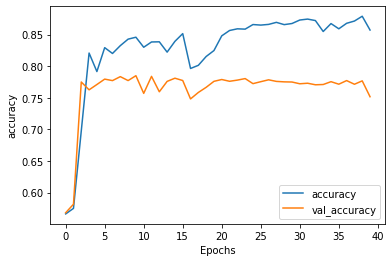

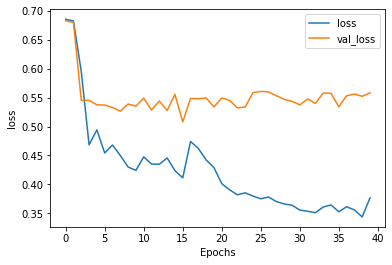

              precision    recall  f1-score   support

           0       0.72      0.98      0.83       886
           1       0.93      0.47      0.62       637

    accuracy                           0.76      1523
   macro avg       0.83      0.72      0.73      1523
weighted avg       0.81      0.76      0.74      1523



In [150]:
num_epochs = 40
history = model.fit(train_padded, train_labels, epochs=num_epochs, validation_split=0.2, verbose=2)
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

report = evaluate(model,test_padded,test_labels)
print(report)

# **GloVe pretrained word embeddings - text-preprocessing WITHOUT stemming**
<a href="toc" id="4"></a>

**text pre-processing**

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# TEXT PRE-PROCESSING WITHOUT STEMMING
 
# import nltk
# import re
# from nltk.stem.porter import *


# nltk.download('stopwords')

# wpt = nltk.WordPunctTokenizer()
# stop_words = nltk.corpus.stopwords.words('english')

# vocab_size = 1000
# embedding_dim = 300
# max_length = 1000
# trunc_type='post'
# padding_type='post'
# oov_tok = "<UNK>"

STEMMING = False
X = X.map(normalize_and_tokenize)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)

tokenizer = Tokenizer(num_words = vocab_size
                      ,oov_token= oov_tok
                     )
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

import numpy as np
train_padded = np.array(train_padded)
train_labels = np.array(y_train)
test_padded = np.array(test_padded)
test_labels = np.array(y_test)


## **LSTMs**
<a href="#toc" id="4a">Table Of Contents</a>

**import pre-trained static embeddings**

In [152]:
# load the GloVe embedding into memory 
import numpy as np
embeddings_index = dict()
f = open("../input/glove6b/glove.6B.300d.txt")

for line in f: 
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs 
    
f.close()
print('Loaded %s word vectors.' %len(embeddings_index))


# create the weight matrix 
missing=0
embedding_matrix = np.zeros((len(tokenizer.word_index.items()) + 1, 300))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: 
        embedding_matrix[i] = embedding_vector
    else:
        missing = missing + 1
print('%d embeddings are missing' %missing)

Loaded 400000 word vectors.
9213 embeddings are missing


In [153]:
import tensorflow as tf
from tensorflow import keras

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(tokenizer.word_index.items()) + 1, embedding_dim, weights = [embedding_matrix], input_length=max_length, trainable=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True,input_shape=(max_length, embedding_dim),dropout=0.5)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 150, 300)          4695000   
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 150, 64)           85248     
_________________________________________________________________
dense_35 (Dense)             (None, 150, 24)           1560      
_________________________________________________________________
dense_36 (Dense)             (None, 150, 1)            25        
Total params: 4,781,833
Trainable params: 4,781,833
Non-trainable params: 0
_________________________________________________________________


Epoch 1/40
77/77 - 6s - loss: 0.6819 - accuracy: 0.5719 - val_loss: 0.6752 - val_accuracy: 0.5804
Epoch 2/40
77/77 - 1s - loss: 0.6230 - accuracy: 0.6497 - val_loss: 0.5846 - val_accuracy: 0.7358
Epoch 3/40
77/77 - 1s - loss: 0.5425 - accuracy: 0.7587 - val_loss: 0.5474 - val_accuracy: 0.7538
Epoch 4/40
77/77 - 1s - loss: 0.5146 - accuracy: 0.7781 - val_loss: 0.5390 - val_accuracy: 0.7583
Epoch 5/40
77/77 - 1s - loss: 0.5025 - accuracy: 0.7874 - val_loss: 0.5390 - val_accuracy: 0.7580
Epoch 6/40
77/77 - 1s - loss: 0.4939 - accuracy: 0.7896 - val_loss: 0.5286 - val_accuracy: 0.7637
Epoch 7/40
77/77 - 1s - loss: 0.4848 - accuracy: 0.7957 - val_loss: 0.5254 - val_accuracy: 0.7629
Epoch 8/40
77/77 - 1s - loss: 0.4805 - accuracy: 0.7974 - val_loss: 0.5139 - val_accuracy: 0.7660
Epoch 9/40
77/77 - 1s - loss: 0.4607 - accuracy: 0.8061 - val_loss: 0.5162 - val_accuracy: 0.7680
Epoch 10/40
77/77 - 1s - loss: 0.4544 - accuracy: 0.8117 - val_loss: 0.5216 - val_accuracy: 0.7646
Epoch 11/40
77/77 -

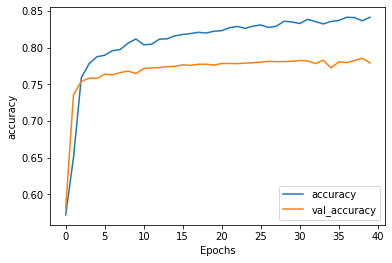

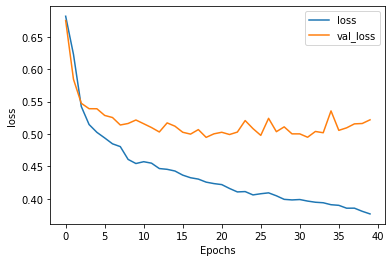

              precision    recall  f1-score   support

           0       0.78      0.90      0.83       886
           1       0.82      0.65      0.72       637

    accuracy                           0.79      1523
   macro avg       0.80      0.77      0.78      1523
weighted avg       0.80      0.79      0.79      1523



In [154]:
num_epochs = 40
BATCH_SIZE = 64
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

history = model.fit(train_padded, train_labels, epochs=num_epochs, validation_split=0.2,batch_size = BATCH_SIZE, verbose=2,callbacks=[callback])
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

report = evaluate(model,test_padded,test_labels)
print(report)

## GRUs
<a href="#toc" id="4b">Table Of Contents</a>

In [155]:
import tensorflow as tf
from tensorflow import keras

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(tokenizer.word_index.items()) + 1, embedding_dim, weights = [embedding_matrix], input_length=max_length, trainable=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32, return_sequences=True,input_shape=(max_length, embedding_dim),dropout=0.5)),
#     tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, 150, 300)          4695000   
_________________________________________________________________
bidirectional_18 (Bidirectio (None, 150, 64)           64128     
_________________________________________________________________
dense_37 (Dense)             (None, 150, 1)            65        
Total params: 4,759,193
Trainable params: 4,759,193
Non-trainable params: 0
_________________________________________________________________


Epoch 1/40
77/77 - 4s - loss: 0.6809 - accuracy: 0.5743 - val_loss: 0.6772 - val_accuracy: 0.5786
Epoch 2/40
77/77 - 1s - loss: 0.6746 - accuracy: 0.5817 - val_loss: 0.6705 - val_accuracy: 0.5862
Epoch 3/40
77/77 - 1s - loss: 0.6025 - accuracy: 0.6674 - val_loss: 0.5366 - val_accuracy: 0.7555
Epoch 4/40
77/77 - 1s - loss: 0.4993 - accuracy: 0.7827 - val_loss: 0.5308 - val_accuracy: 0.7592
Epoch 5/40
77/77 - 1s - loss: 0.4888 - accuracy: 0.7883 - val_loss: 0.5180 - val_accuracy: 0.7652
Epoch 6/40
77/77 - 1s - loss: 0.4780 - accuracy: 0.7954 - val_loss: 0.5169 - val_accuracy: 0.7685
Epoch 7/40
77/77 - 1s - loss: 0.4653 - accuracy: 0.8051 - val_loss: 0.5145 - val_accuracy: 0.7700
Epoch 8/40
77/77 - 1s - loss: 0.4604 - accuracy: 0.8077 - val_loss: 0.5164 - val_accuracy: 0.7731
Epoch 9/40
77/77 - 1s - loss: 0.4542 - accuracy: 0.8105 - val_loss: 0.5261 - val_accuracy: 0.7698
Epoch 10/40
77/77 - 1s - loss: 0.4503 - accuracy: 0.8114 - val_loss: 0.5165 - val_accuracy: 0.7753
Epoch 11/40
77/77 -

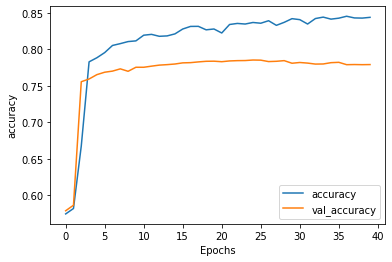

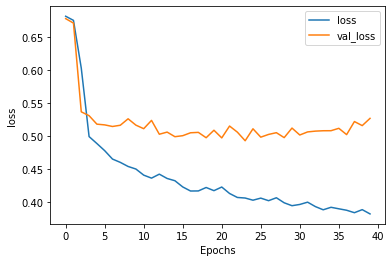

              precision    recall  f1-score   support

           0       0.79      0.83      0.81       886
           1       0.75      0.70      0.73       637

    accuracy                           0.78      1523
   macro avg       0.77      0.77      0.77      1523
weighted avg       0.78      0.78      0.78      1523



In [156]:
num_epochs = 40
BATCH_SIZE = 64
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

history = model.fit(train_padded, train_labels, epochs=num_epochs, validation_split=0.2,batch_size = BATCH_SIZE, verbose=2,callbacks=[callback])
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

report = evaluate(model,test_padded,test_labels)
print(report)

# **GloVe pre-trained static embedding on Twitter data - without STEMMING**

The quality of embeddings is crucial for the performance: we tried another set of pretrained embedding, of dimension 200 instead of 300 but trained on Twitter data.
Since these embeddings may be similar to the dataset we are evaluating, they may lead to a better performance.

## **LSTMs**
<a href="#toc" id="4c">Table Of Contents</a>

**import GloVe static embedding pre trained on twitter data with 200 dimension**

In [157]:

# load the GloVe embedding into memory 
import numpy as np
twitter_embeddings_index = dict()
f = open("../input/glove-global-vectors-for-word-representation/glove.twitter.27B.200d.txt")



for line in f: 
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    twitter_embeddings_index[word] = coefs 
    
f.close()
print('Loaded %s word vectors.' %len(twitter_embeddings_index))


# create the weight matrix 
missing=0
twitter_embedding_matrix = np.zeros((len(tokenizer.word_index.items()) + 1, 200))

for word, i in tokenizer.word_index.items():
    twitter_embedding_vector = twitter_embeddings_index.get(word)
    if twitter_embedding_vector is not None: 
        twitter_embedding_matrix[i] = twitter_embedding_vector
    else:
        missing = missing + 1
print('%d embeddings are missing' %missing)


Loaded 1193514 word vectors.
8205 embeddings are missing


**LSTMs model definition**

In [158]:

import tensorflow as tf
from tensorflow import keras
twitter_embedding_dim = 200
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(tokenizer.word_index.items()) + 1, twitter_embedding_dim, weights = [twitter_embedding_matrix], input_length=max_length, trainable=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True,input_shape=(max_length, twitter_embedding_dim),dropout=0.5)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_23 (Embedding)     (None, 150, 200)          3130000   
_________________________________________________________________
bidirectional_19 (Bidirectio (None, 150, 64)           59648     
_________________________________________________________________
dense_38 (Dense)             (None, 150, 24)           1560      
_________________________________________________________________
dense_39 (Dense)             (None, 150, 1)            25        
Total params: 3,191,233
Trainable params: 3,191,233
Non-trainable params: 0
_________________________________________________________________


Epoch 1/40
77/77 - 5s - loss: 0.6791 - accuracy: 0.5819 - val_loss: 0.6542 - val_accuracy: 0.6347
Epoch 2/40
77/77 - 1s - loss: 0.5596 - accuracy: 0.7456 - val_loss: 0.5528 - val_accuracy: 0.7568
Epoch 3/40
77/77 - 1s - loss: 0.5457 - accuracy: 0.7596 - val_loss: 0.5508 - val_accuracy: 0.7518
Epoch 4/40
77/77 - 1s - loss: 0.5363 - accuracy: 0.7664 - val_loss: 0.5473 - val_accuracy: 0.7569
Epoch 5/40
77/77 - 1s - loss: 0.5267 - accuracy: 0.7740 - val_loss: 0.5364 - val_accuracy: 0.7650
Epoch 6/40
77/77 - 1s - loss: 0.5214 - accuracy: 0.7772 - val_loss: 0.5351 - val_accuracy: 0.7663
Epoch 7/40
77/77 - 1s - loss: 0.5170 - accuracy: 0.7783 - val_loss: 0.5422 - val_accuracy: 0.7626
Epoch 8/40
77/77 - 1s - loss: 0.5111 - accuracy: 0.7835 - val_loss: 0.5298 - val_accuracy: 0.7697
Epoch 9/40
77/77 - 1s - loss: 0.5041 - accuracy: 0.7876 - val_loss: 0.5324 - val_accuracy: 0.7665
Epoch 10/40
77/77 - 1s - loss: 0.5090 - accuracy: 0.7853 - val_loss: 0.5298 - val_accuracy: 0.7679
Epoch 11/40
77/77 -

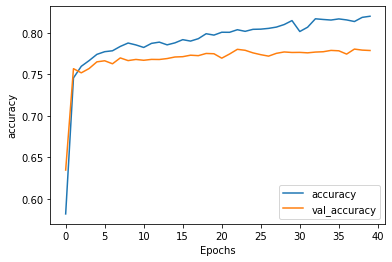

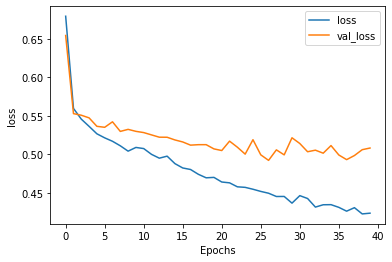

              precision    recall  f1-score   support

           0       0.81      0.80      0.80       886
           1       0.72      0.75      0.73       637

    accuracy                           0.77      1523
   macro avg       0.77      0.77      0.77      1523
weighted avg       0.78      0.77      0.78      1523



In [159]:
num_epochs = 40
BATCH_SIZE = 64
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

history = model.fit(train_padded, train_labels, epochs=num_epochs, validation_split=0.2,batch_size = BATCH_SIZE, verbose=2,callbacks=[callback])
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

report = evaluate(model,test_padded,test_labels)
print(report)

## GRUs
<a href="#toc" id="4d">Table Of Contents</a>

In [160]:
import tensorflow as tf
import keras
twitter_embedding_dim = 200
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(tokenizer.word_index.items()) + 1, twitter_embedding_dim, weights = [twitter_embedding_matrix], input_length=max_length, trainable=True),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32, return_sequences=True,input_shape=(max_length, twitter_embedding_dim))),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
model.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 150, 200)          3130000   
_________________________________________________________________
dropout_10 (Dropout)         (None, 150, 200)          0         
_________________________________________________________________
bidirectional_20 (Bidirectio (None, 150, 64)           44928     
_________________________________________________________________
dense_40 (Dense)             (None, 150, 24)           1560      
_________________________________________________________________
dense_41 (Dense)             (None, 150, 1)            25        
Total params: 3,176,513
Trainable params: 3,176,513
Non-trainable params: 0
_________________________________________________________________


Epoch 1/40
77/77 - 5s - loss: 0.6828 - accuracy: 0.5725 - val_loss: 0.6777 - val_accuracy: 0.5788
Epoch 2/40
77/77 - 1s - loss: 0.6761 - accuracy: 0.5819 - val_loss: 0.6716 - val_accuracy: 0.5879
Epoch 3/40
77/77 - 1s - loss: 0.6158 - accuracy: 0.6665 - val_loss: 0.5306 - val_accuracy: 0.7596
Epoch 4/40
77/77 - 1s - loss: 0.5093 - accuracy: 0.7784 - val_loss: 0.5250 - val_accuracy: 0.7662
Epoch 5/40
77/77 - 1s - loss: 0.4851 - accuracy: 0.7995 - val_loss: 0.5196 - val_accuracy: 0.7738
Epoch 6/40
77/77 - 1s - loss: 0.4792 - accuracy: 0.8002 - val_loss: 0.5180 - val_accuracy: 0.7747
Epoch 7/40
77/77 - 1s - loss: 0.4811 - accuracy: 0.8050 - val_loss: 0.5150 - val_accuracy: 0.7763
Epoch 8/40
77/77 - 1s - loss: 0.4699 - accuracy: 0.8082 - val_loss: 0.5200 - val_accuracy: 0.7755
Epoch 9/40
77/77 - 1s - loss: 0.4648 - accuracy: 0.8083 - val_loss: 0.5123 - val_accuracy: 0.7771
Epoch 10/40
77/77 - 1s - loss: 0.4566 - accuracy: 0.8130 - val_loss: 0.5089 - val_accuracy: 0.7807
Epoch 11/40
77/77 -

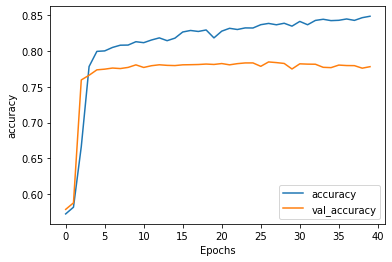

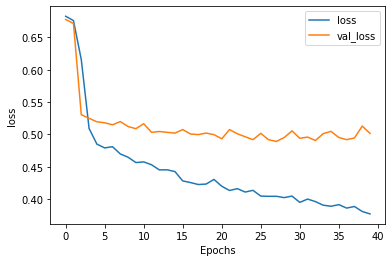

              precision    recall  f1-score   support

           0       0.79      0.84      0.81       886
           1       0.75      0.70      0.72       637

    accuracy                           0.78      1523
   macro avg       0.77      0.77      0.77      1523
weighted avg       0.78      0.78      0.78      1523



In [161]:
num_epochs = 40
BATCH_SIZE = 64
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

history = model.fit(train_padded, train_labels, epochs=num_epochs, validation_split=0.2,batch_size = BATCH_SIZE, verbose=2,callbacks=[callback])
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

report = evaluate(model,test_padded,test_labels)
print(report)

# Contextual Embeddings
<a href="#toc" id="5">Table Of Contents</a>

In [3]:
from transformers import BertTokenizer, TFBertModel
from tqdm.notebook import tqdm

import tensorflow_hub as hub

# bert_model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased",num_labels=2)
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

2022-07-22 17:29:31.878171: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-22 17:29:31.879266: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-22 17:29:31.879979: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-22 17:29:31.880887: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [4]:
max_length = 150

sent= 'how to train the model, lets look at how a trained model calculates its prediction.'
tokens=bert_tokenizer.tokenize(sent)
print(tokens)

tokenized_sequence= bert_tokenizer.encode_plus(sent,add_special_tokens = True,truncation=True,max_length =max_length,
return_attention_mask = True)
tokenized_sequence

['how', 'to', 'train', 'the', 'model', ',', 'lets', 'look', 'at', 'how', 'a', 'trained', 'model', 'calculate', '##s', 'its', 'prediction', '.']


{'input_ids': [101, 2129, 2000, 3345, 1996, 2944, 1010, 11082, 2298, 2012, 2129, 1037, 4738, 2944, 18422, 2015, 2049, 17547, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [5]:
bert_tokenizer.decode(tokenized_sequence['input_ids'])

'[CLS] how to train the model, lets look at how a trained model calculates its prediction. [SEP]'

In [6]:
import tensorflow as tf
import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD, Adam

def bert_encode(data, max_length) :
    input_ids = []
    attention_masks = []

    for text in data:
        encoded = tokenizer.encode_plus(
            text, 
            add_special_tokens=True,
            max_length=max_length,
            pad_to_max_length=True,

            return_attention_mask=True,
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        
    return np.array(input_ids),np.array(attention_masks)

def create_bert(bert_model,max_length):
    
    input_ids = tf.keras.Input(shape=(max_length,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_length,),dtype='int32')

    output = bert_model([input_ids,attention_masks])
    output = output[1]
    output = tf.keras.layers.Dense(32,activation='relu')(output)
    output = tf.keras.layers.Dropout(0.5)(output)
    output = tf.keras.layers.Dense(1,activation='sigmoid')(output)
    
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [7]:
model = create_bert(bert_model,max_length)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 150)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 32)           24608       tf_bert_model[0][1]          

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [25]:
input_ids=[]
attention_masks=[]

for sent in X:
    bert_inp=bert_tokenizer.encode_plus(sent,add_special_tokens = True,truncation=True,max_length =max_length,pad_to_max_length = True,return_attention_mask = True)
    input_ids.append(bert_inp['input_ids'])
    attention_masks.append(bert_inp['attention_mask'])

input_ids=np.asarray(input_ids)
attention_masks=np.array(attention_masks)
y=np.array(y)

train_inp,val_inp,train_label,val_label,train_mask,val_mask=train_test_split(input_ids,y,attention_masks,test_size=0.2)

In [26]:
import tensorflow as tf
import keras

# callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath=model_save_path,save_weights_only=True,monitor='val_loss',mode='min',save_best_only=True),keras.callbacks.TensorBoard(log_dir=log_dir),tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)]
# history=model.fit([train_inp,train_mask],train_label,batch_size=BATCH_SIZE,epochs=10,validation_data=([val_inp,val_mask],val_label),callbacks=callbacks,verbose=2)

history = model.fit(
    [train_inp, train_mask],
    train_label,
    validation_split=0.2, 
    epochs=10,
    batch_size=BATCH_SIZE,
    verbose=2
)



Epoch 1/10
77/77 - 92s - loss: 0.2341 - accuracy: 0.9218 - val_loss: 0.1743 - val_accuracy: 0.9442
Epoch 2/10
77/77 - 89s - loss: 0.1885 - accuracy: 0.9423 - val_loss: 0.1736 - val_accuracy: 0.9458
Epoch 3/10
77/77 - 89s - loss: 0.1650 - accuracy: 0.9516 - val_loss: 0.1863 - val_accuracy: 0.9384
Epoch 4/10
77/77 - 89s - loss: 0.1341 - accuracy: 0.9614 - val_loss: 0.1944 - val_accuracy: 0.9409
Epoch 5/10
77/77 - 89s - loss: 0.1060 - accuracy: 0.9674 - val_loss: 0.2422 - val_accuracy: 0.9269
Epoch 6/10
77/77 - 89s - loss: 0.1134 - accuracy: 0.9643 - val_loss: 0.2441 - val_accuracy: 0.9269
Epoch 7/10
77/77 - 89s - loss: 0.0881 - accuracy: 0.9704 - val_loss: 0.2267 - val_accuracy: 0.9368
Epoch 8/10
77/77 - 89s - loss: 0.0807 - accuracy: 0.9750 - val_loss: 0.2471 - val_accuracy: 0.9319
Epoch 9/10
77/77 - 89s - loss: 0.0705 - accuracy: 0.9772 - val_loss: 0.2513 - val_accuracy: 0.9319
Epoch 10/10
77/77 - 89s - loss: 0.0457 - accuracy: 0.9854 - val_loss: 0.2624 - val_accuracy: 0.9392


In [27]:
report = evaluate(model,[val_inp,val_mask],val_label)
print(report)

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       846
           1       0.94      0.91      0.92       677

    accuracy                           0.93      1523
   macro avg       0.93      0.93      0.93      1523
weighted avg       0.93      0.93      0.93      1523



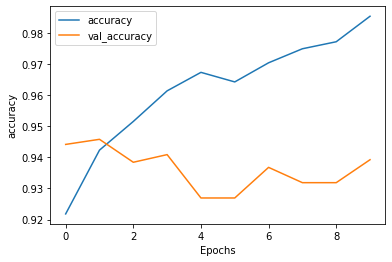

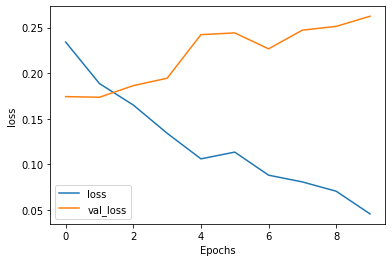

In [30]:
import matplotlib.pyplot as plt
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")